## Inicialización y carga de datos

In [24]:
# Importar librerías
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Carga de datos
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
# Verificar si el índice está ordenado de menor a mayor
print(df.index.is_monotonic)

True


<AxesSubplot:xlabel='datetime'>

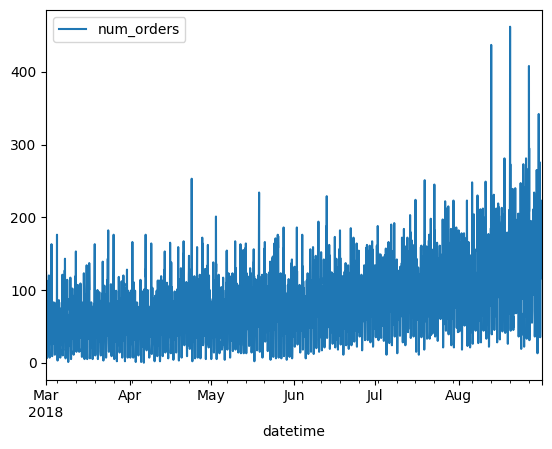

In [ ]:
# Agrupar los datos por intervalos de 1 hora y los suma
df = df.resample('1H').sum()
df.plot()

In [7]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Conclusiones: Al hacer el resample a horas, se disminuye notoriamente el número de registros/filas del DF.

## Análisis

In [9]:
df.index.to_series().dt.floor('H').value_counts().sort_index().head(20)

2018-03-01 00:00:00    1
2018-03-01 01:00:00    1
2018-03-01 02:00:00    1
2018-03-01 03:00:00    1
2018-03-01 04:00:00    1
2018-03-01 05:00:00    1
2018-03-01 06:00:00    1
2018-03-01 07:00:00    1
2018-03-01 08:00:00    1
2018-03-01 09:00:00    1
2018-03-01 10:00:00    1
2018-03-01 11:00:00    1
2018-03-01 12:00:00    1
2018-03-01 13:00:00    1
2018-03-01 14:00:00    1
2018-03-01 15:00:00    1
2018-03-01 16:00:00    1
2018-03-01 17:00:00    1
2018-03-01 18:00:00    1
2018-03-01 19:00:00    1
Name: datetime, dtype: int64

In [10]:
df.index.to_series().dt.floor('H').value_counts().sort_index().tail(20)

2018-08-31 04:00:00    1
2018-08-31 05:00:00    1
2018-08-31 06:00:00    1
2018-08-31 07:00:00    1
2018-08-31 08:00:00    1
2018-08-31 09:00:00    1
2018-08-31 10:00:00    1
2018-08-31 11:00:00    1
2018-08-31 12:00:00    1
2018-08-31 13:00:00    1
2018-08-31 14:00:00    1
2018-08-31 15:00:00    1
2018-08-31 16:00:00    1
2018-08-31 17:00:00    1
2018-08-31 18:00:00    1
2018-08-31 19:00:00    1
2018-08-31 20:00:00    1
2018-08-31 21:00:00    1
2018-08-31 22:00:00    1
2018-08-31 23:00:00    1
Name: datetime, dtype: int64

Con esto confirmamos que cada línea únicamente tiene un resultado y también nos sirve para confirmar las fechas que nos había arrojado la función info().

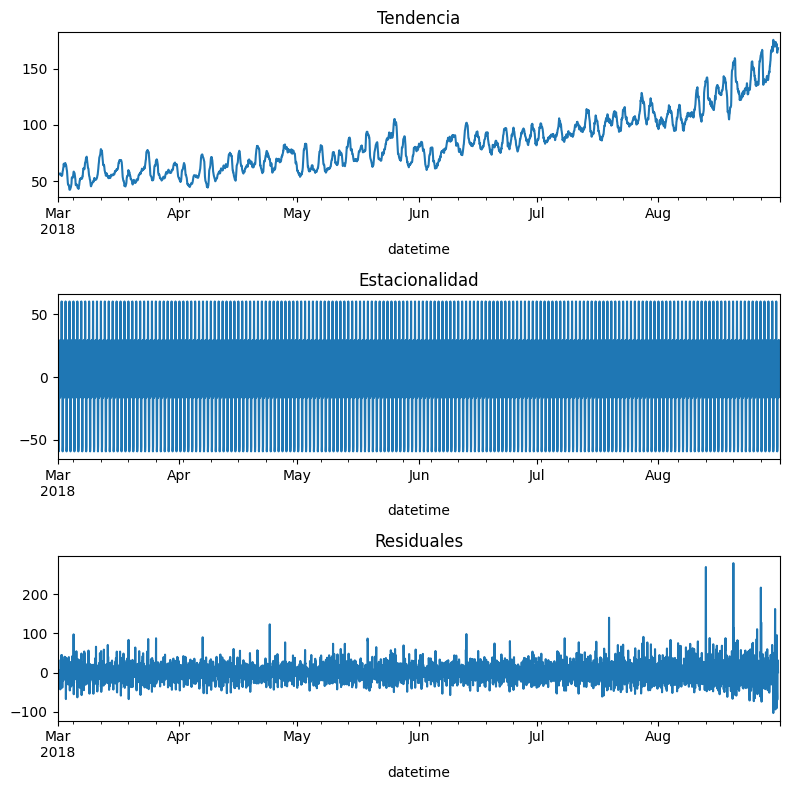

In [11]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(8,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout()

1. Tendencia: es ascendente a lo largo del tiempo. Esto demuestra un incremento de la demanda mes a mes.
2. Estacionalidad: se ve muy rara, como si hubiera tantos datos que la gráfica se ve muy denso y aplastado. 
3. Residuales: Bastante estables en amplitud, con un poco de más distorsión al final, lo cual tiene lógica si se toma en cuenta la primera gráfica.

**Analizando la estacionalidad**

<AxesSubplot:title={'center':'Promedio por hora del día'}, xlabel='hour'>

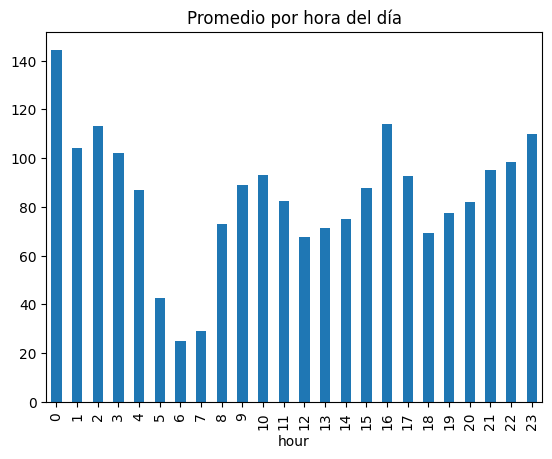

In [12]:
df['hour'] = df.index.hour
df.groupby('hour')['num_orders'].mean().plot(kind='bar', title='Promedio por hora del día')

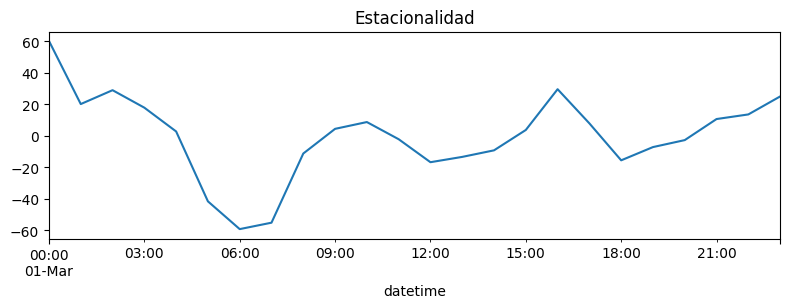

In [13]:
plt.figure(figsize=(8,8))

plt.subplot(312)
decomposed.seasonal['01 March 2018'].plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.tight_layout()

Debido a que la estacionalidad por hora tenía tantos datos, era imposible distinguir patrones, por eso decidí obtenerla por día, especificamente, me enfoqué en el día 1 de marzo de 2018. Concluí algunos puntos importantes:
1. A las 00 horas se alcanza el punto máximo de los pedidos de taxis en los aeropuertos, esta tendencia venía subiendo desde las 18 horas. Esto tiene varias razones: a esa hora otros transportes públicos como el autobús o el metro no están funcionando, por lo que el taxi es la única opción. Tampoco sería lo normal pedirle a un familiar/amigo que pase por ti a esa hora, otra razón para que tomar un taxi sea la única alternativa. 
2. A las 6 am se alcanza el punto más bajo de pedidos de taxis, seguramente es una hora en la que no llegan muchos vuelos.
3. Hay otro repunte al rededor de las 4 pm, seguramente hay un mayor número de aterrizajes a esa hora.

## Formación

In [14]:
df = df.drop('hour', axis=1)

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 4, 4)
print(df.head())

                     num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124  2018      3    1          3    NaN    NaN   
2018-03-01 01:00:00          85  2018      3    1          3  124.0    NaN   
2018-03-01 02:00:00          71  2018      3    1          3   85.0  124.0   
2018-03-01 03:00:00          66  2018      3    1          3   71.0   85.0   
2018-03-01 04:00:00          43  2018      3    1          3   66.0   71.0   

                     lag_3  lag_4  rolling_mean  
datetime                                         
2018-03-01 00:00:00    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN           NaN  
2018-03-01 03:00:00  124.0    NaN           NaN  
2018-03-01 04:00:00   85.0  124.0          86.5  


In [16]:
df = df.dropna()
print(df.head())

                     num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-03-01 04:00:00          43  2018      3    1          3   66.0   71.0   
2018-03-01 05:00:00           6  2018      3    1          3   43.0   66.0   
2018-03-01 06:00:00          12  2018      3    1          3    6.0   43.0   
2018-03-01 07:00:00          15  2018      3    1          3   12.0    6.0   
2018-03-01 08:00:00          34  2018      3    1          3   15.0   12.0   

                     lag_3  lag_4  rolling_mean  
datetime                                         
2018-03-01 04:00:00   85.0  124.0         86.50  
2018-03-01 05:00:00   71.0   85.0         66.25  
2018-03-01 06:00:00   66.0   71.0         46.50  
2018-03-01 07:00:00   43.0   66.0         31.75  
2018-03-01 08:00:00    6.0   43.0         19.00  


In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4412 entries, 2018-03-01 04:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4412 non-null   int64  
 1   year          4412 non-null   int64  
 2   month         4412 non-null   int64  
 3   day           4412 non-null   int64  
 4   dayofweek     4412 non-null   int64  
 5   lag_1         4412 non-null   float64
 6   lag_2         4412 non-null   float64
 7   lag_3         4412 non-null   float64
 8   lag_4         4412 non-null   float64
 9   rolling_mean  4412 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 379.2 KB
None


## Prueba

In [18]:
# Definir variables independientes y dependiente
X = df.drop('num_orders', axis=1)
y = df['num_orders']

# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Definir modelos de regresión
linear_regression = LinearRegression()
random_forest = RandomForestRegressor(random_state=123)
lightgbm = LGBMRegressor(random_state=123)

In [20]:
# Definir hiperparámetros
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10, -1]
}

In [22]:
# GridSearch para Random Forest
grid_search_rf = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# GridSearch para LightGBM
grid_search_lgb = GridSearchCV(
    estimator=lightgbm,
    param_grid=param_grid_lgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [25]:
# Evaluar Linear Regression
start_lr = time.time()
scores_lr = cross_val_score(linear_regression, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
end_lr = time.time()

# Evaluar Random Forest con GridSearch
start_rf = time.time()
grid_search_rf.fit(X_train, y_train)
end_rf = time.time()

# Evaluar LightGBM con GridSearch
start_lgb = time.time()
grid_search_lgb.fit(X_train, y_train)
end_lgb = time.time()

# Resultados de tiempos
print(f"Linear Regression time: {end_lr - start_lr:.2f} seconds")
print(f"Random Forest GridSearchCV time: {end_rf - start_rf:.2f} seconds")
print(f"LightGBM GridSearchCV time: {end_lgb - start_lgb:.2f} seconds")

# Resultados de métricas (convertidos a positivos)
print("Linear Regression CV RMSE:", -scores_lr.mean())
print("Random Forest best CV RMSE:", -grid_search_rf.best_score_)
print("LightGBM best CV RMSE:", -grid_search_lgb.best_score_)

# Mejores hiperparámetros
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")
print(f"Best LightGBM Params: {grid_search_lgb.best_params_}")

Linear Regression time: 0.02 seconds
Random Forest GridSearchCV time: 348.62 seconds
LightGBM GridSearchCV time: 36.71 seconds
Linear Regression CV RMSE: 33.513652898063626
Random Forest best CV RMSE: 32.81757626611292
LightGBM best CV RMSE: 32.62478045907532
Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best LightGBM Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [27]:
# Obtener los mejores modelos (ya ajustados vía GridSearchCV)
best_rf = grid_search_rf.best_estimator_
best_lgb = grid_search_lgb.best_estimator_

# Entrenar regresión lineal sobre todo X_train (porque solo la habíamos validado con CV antes)
linear_regression.fit(X_train, y_train)

# Realizar predicciones
y_pred_lr = linear_regression.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_lgb = best_lgb.predict(X_test)

# Función para evaluar RMSE
def evaluate_rmse(y_test, y_pred, model_name):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"{model_name} RMSE on Test Set: {rmse:.4f}")

# Evaluar cada modelo
evaluate_rmse(y_test, y_pred_lr, "Linear Regression")
evaluate_rmse(y_test, y_pred_rf, "Random Forest")
evaluate_rmse(y_test, y_pred_lgb, "LightGBM")

Linear Regression RMSE on Test Set: 31.4938
Random Forest RMSE on Test Set: 30.4821
LightGBM RMSE on Test Set: 30.5294


Conclusión: como se puede observar, al momento de hacer la prueba, el modelo con el menor RMSE es el de Random Forest por muy poco respecto al de LightGBM, por lo que sería el modelo elegido, el que tiene menos errores. Sin embargo, es importante destacar que al momento del entrenamiento, tiene una duración de casi 10 veces más. 